In [1]:
import torch
import torch.nn as nn
import numpy as np
from random import random
np.seterr(all='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
# setup matplotlib
import matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    SAVE_PLOTS = False
else:
    matplotlib.use('Agg')
    SAVE_PLOTS = True
import matplotlib.pyplot as plt


# plt.rcParams['figure.figsize'] = [10, 5]
# plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [3]:
from utils import plot_spikes_in_time, print_and_plot_accuracy_metrics, plot_metrics
from scnn import SNN
from scnn.Spike.readin import ReadInLayer
from scnn.optim import RAdam

# from data.data_augmentor import data_augment, batchify, GESTURE_MAPPING
from tools.time_expector import TimeExpector
from tools.notify import notify
time_expector = TimeExpector()

In [4]:
#======================================== Data ========================================
# from navgesture import load_all, classes, num_of_classes
# DATA_PATH = './drive/My Drive/Colab Notebooks/dataset/navgesture/user01/*'
# DATA_PATH = './navgesture/user*/*'

from data import load_all, classes, num_of_classes
# DATA_PATH = './dvs/'
DATA_PATH = '/media/aref/TeraDisk/Workspace/dvs'

#===================================== Parameters =====================================
BATCH_SIZE = 16
IMAGE_SIZE = (128, 128)
IMAGE_SCALE = (.4, .4)
FRAMES = 20
FRAME_LENGTH = 5000 # in timestamps
POLARITY_MODE = 'accumulative' #'accumulative' 'twolayer' 'onelayer' 'ignore'

LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
EPOCHS = 40
NET_STR = 'd(128)'

#====================================== Configs  ======================================
read_in_channels = 2 if POLARITY_MODE in ['accumulative', 'twolayer'] else 1
device = torch.device('cpu')# if not torch.cuda.is_available() else 'cuda')
dtype = torch.float
print("Device:", device)

Device: cpu


In [5]:
def train_test_split(x_data, y_data, test_size):
    def _select(data, indices):
        return [data[i] for i in indices]
        
    idx_train = []
    idx_test = []
    for i in range(len(x_data)):
        if random() > test_size:
            idx_train.append(i)
        else:
            idx_test.append(i)

    return _select(x_data, idx_train), _select(x_data, idx_test), _select(y_data, idx_train), _select(y_data, idx_test)


In [6]:
def data_hist(y_data):
    hist = {i:0 for i in range(num_of_classes)}
    for i in y_data:
        hist[i] += 1
    
    max_data = max(hist.values())
    for k, i in hist.items():
        print('%2d)' % k, '#' * int(30 * i / max_data), '(%d)' % i)

In [7]:
data_loading_config = {
    'batch_size': BATCH_SIZE,
    'image_size': IMAGE_SIZE,
    'image_scale': IMAGE_SCALE,
    'frames': FRAMES,
    'frame_len': FRAME_LENGTH,
    'polarity_mode': POLARITY_MODE,
    'data_path': DATA_PATH,
    'max_read_file': 40,
}

x_cache_train = x_cache_test = y_cache_train = y_cache_test = None

def load_cache():
    global x_cache_train, x_cache_test, y_cache_train, y_cache_test
    
    x_cache_data = []
    y_cache_data = []

    for xc, yc in load_all(**data_loading_config):
        x_cache_data.append(xc)
        y_cache_data.append(yc)

    x_cache_train, x_cache_test, y_cache_train, y_cache_test = train_test_split(
        x_cache_data,
        y_cache_data,
        test_size=0.3
    )

    print('[Done]')
    print('Train Dataset Size: %d * %d' % (len(x_cache_train), BATCH_SIZE))
    print('Test Dataset Size: %d * %d' % (len(x_cache_test), BATCH_SIZE))
    print('--------------------------------------------------\n')
    print('Train Data Histogram:')
    data_hist(y_cache_train)
    print('--------------------------------------------------\n')
    print('Test Data Histogram:')
    data_hist(y_cache_test)
    print('==================================================\n')
    if len(x_cache_test) == 0 or len(x_cache_train) == 0:
        raise Exception('not enough data collected')

In [8]:
def batchify(data, batch_size):
    x_batch = []
    y_batch = []
    for x_chunk, y_chunk in data:
        if len(x_batch) == batch_size:
            yield x_batch, y_batch
            x_batch = []
            y_batch = []
        x_batch.append(x_chunk.to_dense().numpy() if x_chunk.layout == torch.sparse_coo else x_chunk.numpy())
        y_batch.append(y_chunk)

    
def load_data(trail=''):
    if x_cache_train is None or x_cache_test is None:
        load_cache()
    
    trail = trail.replace('acc_', '')
    zipper = zip(x_cache_train, y_cache_train) if trail == 'train' else zip(x_cache_test, y_cache_test)
    for x_data, y_data in batchify(zipper, BATCH_SIZE):
#         yield np.array(x_data)[:, 0, :, :, :, :], np.array(y_data)[:,0]
        yield np.array(x_data).reshape(BATCH_SIZE, FRAMES, read_in_channels, 128, 128), np.array(y_data)

Network Summery:
# | name         | shape         | parameters
0 | ReadinLayer  | (128, 128)x 2 | N/A       
1 | maxPool2D    | [64, 64]x 2   | N/A       
  |              |               |           
2 | Dense        | 128           | 1048576   
3 | ReadoutLayer | 11            | 1408      

npy format events data root /media/aref/TeraDisk/Workspace/dvs/events_npy/train, /media/aref/TeraDisk/Workspace/dvs/events_npy/test already exists
frames data root /media/aref/TeraDisk/Workspace/dvs/frames_num_20_split_by_number_normalization_None already exists.
npy format events data root /media/aref/TeraDisk/Workspace/dvs/events_npy/train, /media/aref/TeraDisk/Workspace/dvs/events_npy/test already exists
frames data root /media/aref/TeraDisk/Workspace/dvs/frames_num_20_split_by_number_normalization_None already exists.
[Done]
Train Dataset Size: 827 * 16
Test Dataset Size: 358 * 16
--------------------------------------------------

Train Data Histogram:
 0) ############# (65)
 1) #############

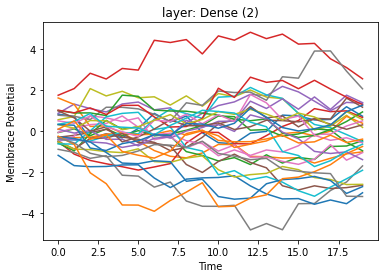

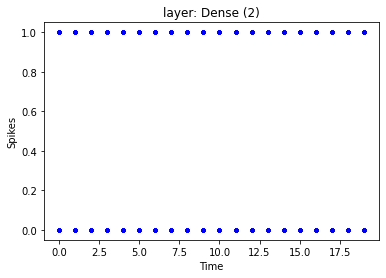

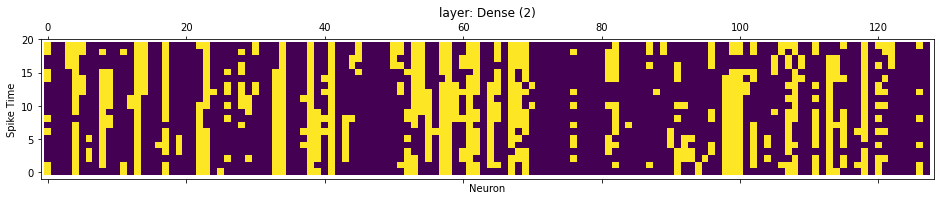

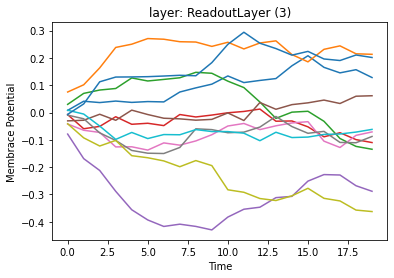

In [9]:
#====================================== Network Begining =====================================
network = SNN(
    device=device,
    dtype=dtype,
    input_layer=ReadInLayer(
        input_shape=(128,128),
        input_channels=read_in_channels
    )
)

network.network.time_expector = time_expector
# network.notifier = notify # FIXME
network.add_pool2d(input_shape=(128,128), kernel_size=(2,2), reduction='max')


#===================================== Network Structure =====================================

network.parse_str(NET_STR)

# network.add_conv3d(
#     output_channels=128,
#     kernel_size=(1,3,3),
#     dilation=(1,1,1),
#     lateral_connections=False,
#     recurrent=False,
#     w_init_mean=0.00,
#     w_init_std=0.05
# )
# network.add_pool2d(kernel_size=(2,2), reduction='max')


# network.add_dense(
#     output_shape=5,
#     w_init_mean=0.0,
#     w_init_std=0.3,
#     lateral_connections=True,
#     recurrent=False,
# #     dropout_prob=0.3,
# )


#=================================== Network Finalization ====================================
network.add_readout(
    output_shape=num_of_classes,
    time_reduction="max",

    w_init_mean=0.0,
    w_init_std=0.3
)
network.compile()
network.print_summery()
# print('Network Summery:', network)
network.plot_one_batch(load_data('train'))

In [10]:
result_file = open('./logs/results.log', 'a+') if SAVE_PLOTS else None
opt = RAdam(network.get_trainable_parameters(LEARNING_RATE, WEIGHT_DECAY))
# opt = torch.optim.SGD(network.get_trainable_parameters(LEARNING_RATE, WEIGHT_DECAY), lr=LEARNING_RATE, momentum=0.9)

res_metrics = network.fit(
    load_data,
    epochs=EPOCHS,
    optimizer=opt,
    result_file=result_file,
    save_checkpoints=False, #SAVE_PLOTS
)
plot_metrics(res_metrics, save_plot_path='./logs/metrics_' if SAVE_PLOTS else None)

if SAVE_PLOTS:
    result_file.close()

In [11]:
# network.save('./logs/save_network.net')
# network.load('./logs/save_network.net')

Layer 0: average number of spikes=0.8139
Layer 1: average number of spikes=1.4584
Layer 2: average number of spikes=0.2707


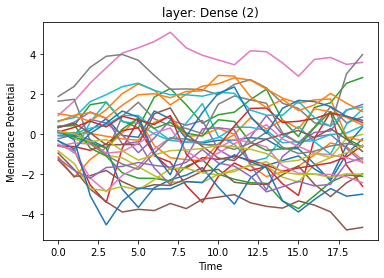

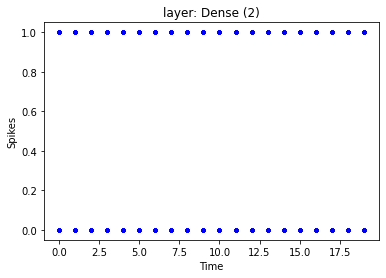

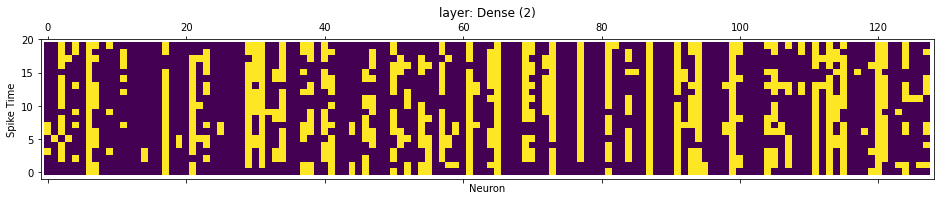

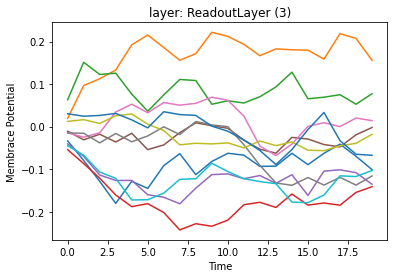


----------------------------------------
Final Train Accuracy=5.27%
Final Test Accuracy=5.97%


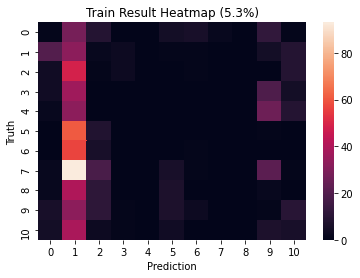

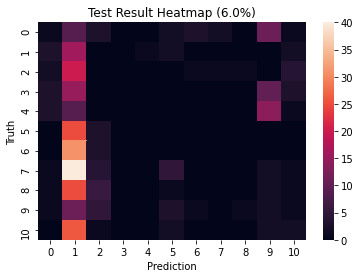

In [12]:
network.plot_one_batch(load_data('test'))
print_and_plot_accuracy_metrics(
    network, 
    load_data('acc_train'), 
    load_data('acc_test'), 
    save_plot_path='./logs/truth_' if SAVE_PLOTS else None
)